
# Auto-Remove Unwanted Objects with YOLO, SAM & CLIP

This notebook integrates:
1. **YOLOv8** for object detection (bounding boxes & classes)  
2. **SAM** (Segment Anything) for precise masks per detection  
3. **CLIP** for semantic scoring: compares each region to text prompts ("foreground subject" vs. "background clutter")  
4. **Heuristic scoring** combining CLIP similarity, YOLO confidence, and spatial features  

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import clip
from segment_anything import sam_model_registry, SamPredictor
from ultralytics import YOLO
from PIL import Image
import math

# Load models
yolo = YOLO("yolov8s")
SAM_CHECKPOINT = "sam_vit_b_01ec64.pth"
sam = sam_model_registry["vit_b"](checkpoint=SAM_CHECKPOINT)
predictor = SamPredictor(sam)
clip_model, preprocess_clip = clip.load("ViT-B/32")
clip_model.eval()

# Prepare text features
foreground_prompts = [
    "a photo of a person", "a group of people", "a child",
    "a dog", "a cat", "a bird", "a horse", "wildlife",
    "a car", "a motorcycle", "a bicycle", "a boat",
    "a chair", "a table", "a sofa", "a bed",
    "a smartphone", "a laptop", "a camera",
    "a building", "a bridge", "a road",
]

background_prompts = [
    "a blurred person", "person not in focus", "dustbin", "pole", "random objects", "blurred object",
    "background clutter", "trash can", "plastic bottle", "paper bag", "street pole", "a crowd", "a truck", "a lamp", "a sign",
    "floor", "wall", "concrete", "texture", "messy background", "unimportant object"
]

prompts = foreground_prompts + background_prompts

with torch.no_grad():
    text_tokens = clip.tokenize(prompts)
    text_features = clip_model.encode_text(text_tokens)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

def sigmoid(x): return 1/(1+math.exp(-x))


In [31]:

def centre_score(xs, ys, cx, cy):
    mx, my = int(xs.mean()), int(ys.mean())
    dist = np.sqrt((mx - cx)**2 + (my - cy)**2)
    norm_dist = dist / np.sqrt(cx**2 + cy**2)
    center_score = norm_dist

    return center_score

def show_overlay(image, mask, title="Overlay"):
    overlay = image.copy()
    overlay[mask] = np.random.randint(0, 255, size=3)
    blended = cv2.addWeighted(image, 0.5, overlay, 0.5, 0)
    plt.figure(figsize=(6,6))
    plt.imshow(blended)
    plt.title(title)
    plt.axis('off')
    plt.show()


In [32]:

def process_with_semantic(image_path, score_thresh=0.3, max_size=512):
    img_bgr = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w = img_rgb.shape[:2]
    cx, cy = w // 2, h // 2

    if max(h, w) > max_size:
        scale = max_size / max(h, w)
        img_rgb = cv2.resize(img_rgb, (int(w*scale), int(h*scale)))
        h, w = img_rgb.shape[:2]

    # YOLO detection
    # yolo = YOLO("yolov8n")
    res = yolo(img_rgb)
    boxes = res[0].boxes.xyxy
    confs = res[0].boxes.conf if res[0].boxes.conf is not None else []
    classes = res[0].boxes.cls if res[0].boxes.cls is not None else []

    # SAM masks per box
    predictor.set_image(img_rgb)
    masks = []
    for box in boxes:
        box = np.array(box)
        masks_list, _, _ = predictor.predict(box=box, multimask_output=False)
        masks.append(masks_list[0])

    # CLIP scoring
    region_scores = []
    for mask in masks:
        ys, xs = np.where(mask)
        if len(xs) == 0:
            region_scores.append(1.0)
            continue
        region = img_rgb[ys.min():ys.max(), xs.min():xs.max()]
        image_clip = preprocess_clip(Image.fromarray(region)).unsqueeze(0)
        with torch.no_grad():
            feat = clip_model.encode_image(image_clip)
            feat = feat / feat.norm(dim=-1, keepdim=True)
            sims = (feat @ text_features.T).squeeze(0).numpy()
        
        max_idx = np.argmax(sims)
        max_sim = sims[max_idx]
        is_background = max_idx >= len(foreground_prompts)

        region_scores.append((max_sim, is_background))

    # Final scoring and visualize
    for i, mask in enumerate(masks):
        print(f"Region {i}: conf={confs[i]:.2f}, sem_score={region_scores[i][0]:.2f}")
        # if(region_scores[i][1] == 1):
        #     ys, xs = np.where(mask)
        #     if len(xs) == 0:
        #         continue

        #     fs = 1 * sigmoid(region_scores[i][0]) + 1 * centre_score(xs, ys, cx, cy)
            
        #     if fs > score_thresh:
        #         show_overlay(img_rgb, mask, title=f"Remove Region {i}")
        show_overlay(img_rgb, mask, title=f"Remove Region {i}")




0: 640x640 5 persons, 1 bicycle, 2 cars, 1 bus, 176.9ms
Speed: 9.1ms preprocess, 176.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


C:\Users\Dhairya Arora\AppData\Local\Temp\ipykernel_22208\2413545582.py:23: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  box = np.array(box)


Region 0: conf=0.94, sem_score=0.28


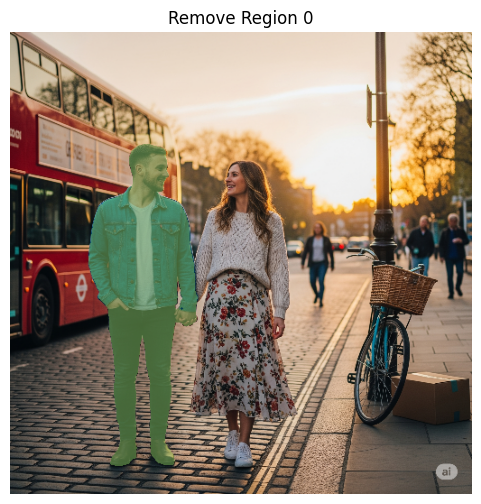

Region 1: conf=0.89, sem_score=0.24


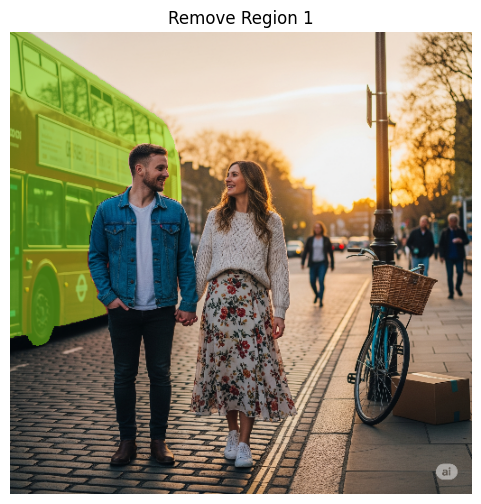

Region 2: conf=0.86, sem_score=0.32


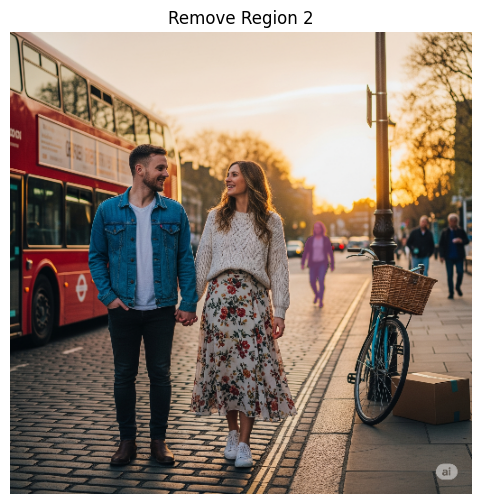

Region 3: conf=0.86, sem_score=0.30


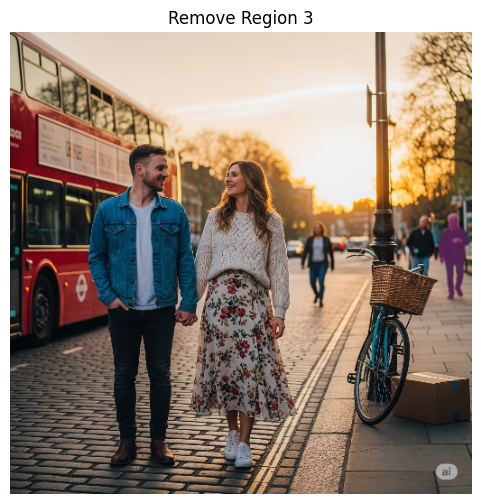

Region 4: conf=0.85, sem_score=0.27


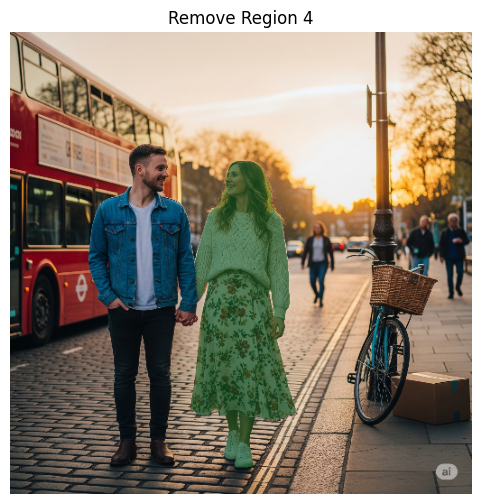

Region 5: conf=0.84, sem_score=0.28


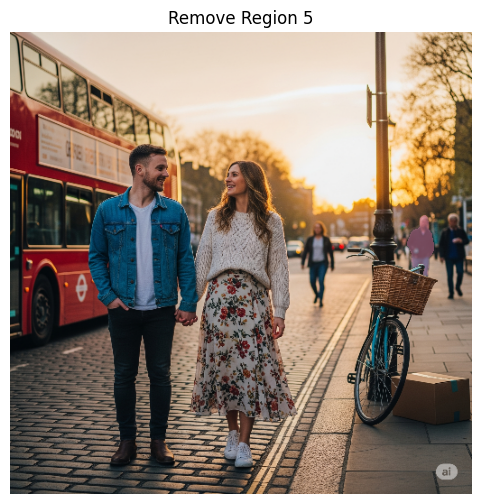

Region 6: conf=0.70, sem_score=0.26


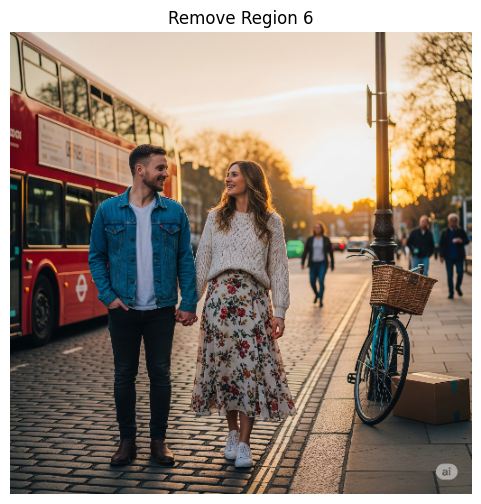

Region 7: conf=0.44, sem_score=0.26


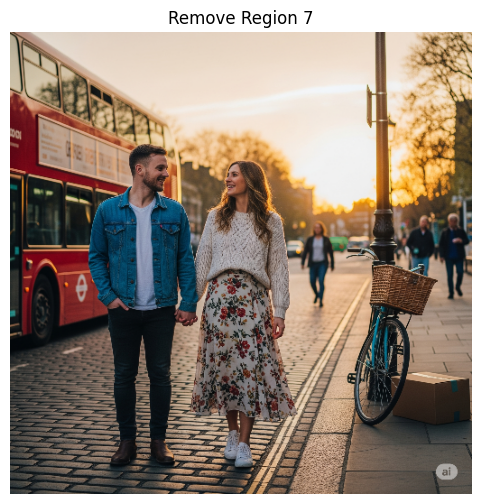

Region 8: conf=0.43, sem_score=0.28


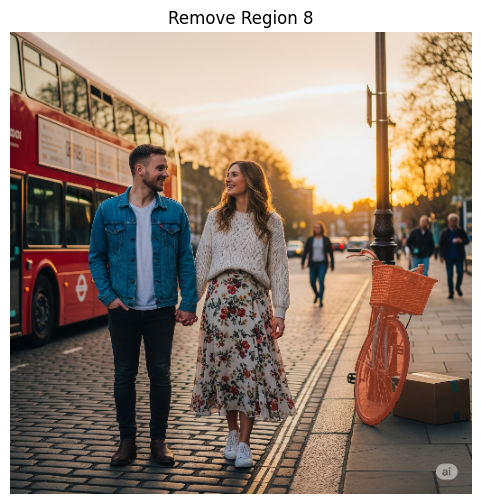

In [33]:

# Update this path to test
IMAGE_PATH = "images/image3.png"
process_with_semantic(IMAGE_PATH, score_thresh=0.35)
